# Ensemble

앙살블(Ensemble)이란, 주어진 데이터로 여러 개의 예측 모델을 만들어 조합하여, 하나의 최종 예측 모델을 만드는 방법으로, 여러 개의 분류 모형에 의한 결과를 종합하여 정확도를 높인다. 앙상블은 각각의 모델이 가진 장점은 취하면서 단점은 보완하기 때문에 최적의 단일 모델을 뛰어 넘는 성능을 보인다.

# 1. 투표 기반 분류기

정확도가 80%인 분류기 여러 개를 훈련 시켰을 때, 더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다. 이렇게 다수결 투표로 정해지는 분류기를 **직접 투표(hard voting) 분류기**라고 한다.

이런 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많다. 각 분류기가 약한 학습기(weak learner, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는) **강한 학습기**가 될 수 있다.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
                estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
                voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.888


# 2. Bagging & Pasting

다양한 분류기를 만드는 또 다른 방법은 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것이다.

훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **Bagging(Bootstrap Aggregating)** 이라 하며, 중복을 허용하지 않고 샘플링하는 방식을 **Pasting**이라고 한다.

![Bagging](https://www.dropbox.com/s/h0xob2027whpcn3/Bagging.jpg?raw=1)

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 수집 함수는 전형적으로 분류일 떄는 **최빈값**(직접 투표 분류기처럼 가장 많은 예측 결과)이고 회귀에서는 **평균**을 계산한다.

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소한다. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


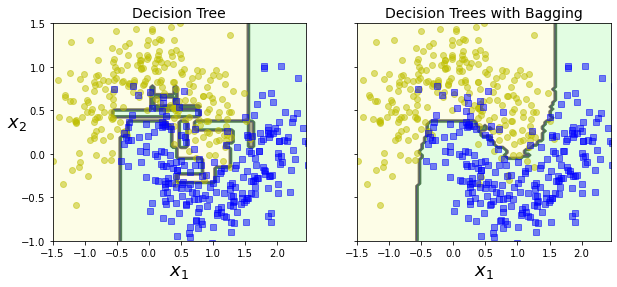

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

위 그림은 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교한 것이다. 여기에서 볼 수 있듯이 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것으로 보인다. 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다).

## 2.1 OOB(Out-of-bag) 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링 되고 어떤 것은 전혀 선택되지 않을 수 있다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다 선택되지 않은 훈련 샘플의 나머지 37%를 oob 샘플이라고 부른다. 예측기마다 남겨진 37%는 모두 다르다.

데이터가 충분히 큰 경우, 각 데이터가 Bootstrap을 통한 train set에서 제외될 확률은 약 36.78%이다.  
$$\lim_{n \to \infty}\left(1-\frac{1}{n}\right)^n = e^{-1} = 0.3678$$

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

In [15]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), n_estimators=500,
            bootstrap=True, n_jobs=1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.904

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# 3. 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원한다. 샘플링은 *max_features*, *bootstrap_features* 두 매개변수로 조절한다.  
작동 방식은 *max_samples*, *bootstrap*과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다. 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.

# 4. 랜덤 포레스트

랜덤 포레스트는 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블이다. 전형적으로 *max_samples*를 훈련 세트의 크기로 지정한다.

BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있다.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

RandomForestClassifier는 트리 성장의 조절을 위한 DecisionTreeClassifier의 매개변수와 앙상블 자체를 제어하는데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있다.

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다.

## 4.1 엑스트라 트리

랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 선택된 특성의 서브셋을 만들어 분할에 사용한다.  
이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리 앙상블 이라고 부른다.

## 4.2 특성 중요도

랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다. 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. 더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 여관된 훈련 샘플 수와 같다.

훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결과값을 정규화한다.

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09342043939427146
sepal width (cm) 0.02366455744315952
petal length (cm) 0.43824759479403247
petal width (cm) 0.44466740836853663


# 5. 부스팅

부스팅은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법이다. 부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것이다. 부스팅 방법에는 여러 가지가 있지만 가장 인기있는 것은 **에이다부스트(Adaptive Boosting)** 와 **그레이언트 부스팅(Gradient Boosting)** 이다.

## 5.1 에이다부스트

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다.  
1. 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만든다.
2. 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
3. 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측한다.
4. 다시 가중치를 업데이트한다.  

이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=1990)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=1990)

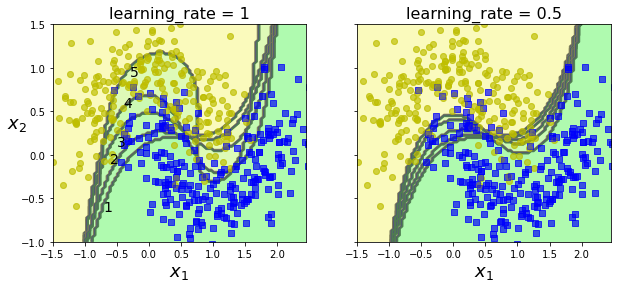

In [21]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

위 그림에서 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌고, 따라서 두 번째 분류기는 이 샘플들을 더 정확하게 예측하게 된다.  
오른쪽 그래프는 학습률을 반으로 낮춘 것으로, 잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아진다.

모든 예측기가 훈련을 마치면 이 앙상블은 배깅과 비슷한 방식으로 예측을 만든다. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.

## 5.2 그레디언트 부스팅

그레디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다. 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습한다.

In [1]:
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [24]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [25]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [27]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(y_pred)

[0.75026781]


In [28]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

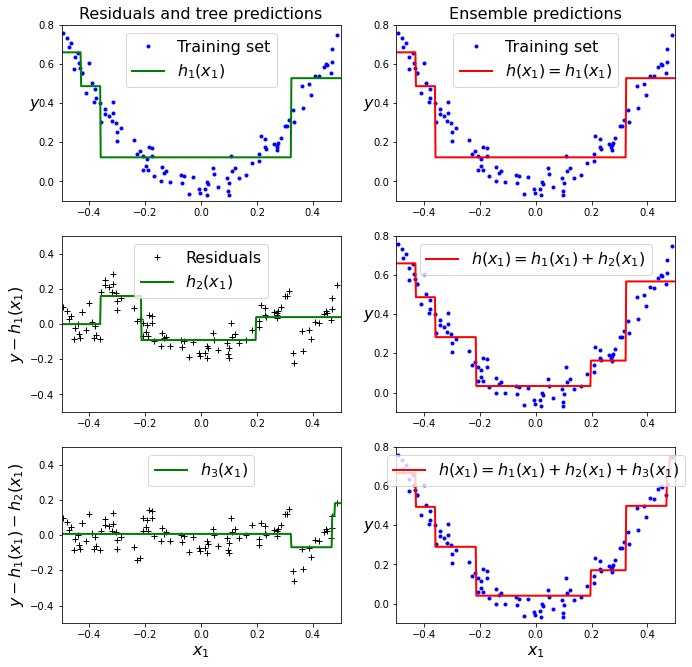

In [29]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

위 그림의 왼쪽 열은 이 세 트리의 예측이고 오른쪽 열은 앙상블의 예측이다. 첫 번째 행에서는 앙상블에 트리가 하나만 있어서 첫 번째 트리의 예측과 완전히 같다. 두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습되었다. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 볼 수 있다. 비슷하게 세 번째 행에서는 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련되었다. 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있다.

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

*learning_rate* 매개변수가 각 트리의 기여 정도를 조절한다. 이를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아진다. 이는 **축소(SHrinkage)** 라고 부르는 규제 방법이다.

In [31]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

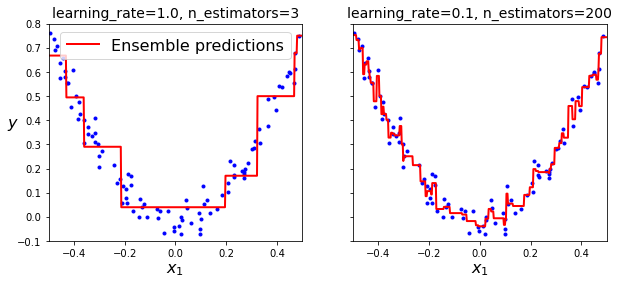

In [33]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

위 그림은 작은 학습률로 훈련시킨 두 개의 GBRT 앙상블을 보여준다. 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면 오른쪽은 트리가 너무 많아 훈련 세트에 과대적합되었다.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=53)

In [35]:
min_error = np.min(errors)

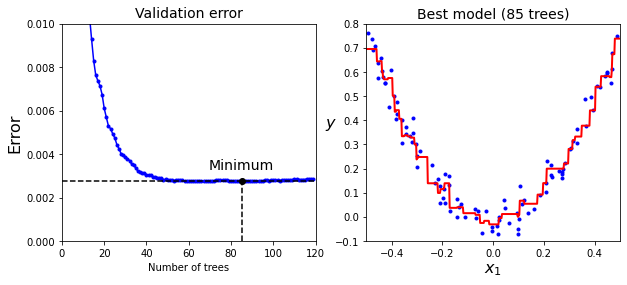

In [36]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

최적의 트리 수를 찾기 위해 조기 종료 기법을 사용할 수 있다. 간단하게 구현하려면 *staged_predict()* 메서드를 사용한다.  
이 메서드는 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환한다. 다음 코드는 위 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다. 그리고 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킨다.

In [37]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # 조기 종료

In [38]:
print(gbrt.n_estimators)

69


In [39]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002750279033345716


GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정한 수 있는 *subsample* 매개변수도 지원한다. 편향이 높아지는 대신 분산이 낮아지게 되고 훈련 속도를 상당히 높인다. 이런 기법을 **확률적 그레디언트 부스팅(Stochastic Gradient Boosting)** 이라고 한다.

# 6. 스태킹

스태킹은 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 같은)를 사용하는 대신 취합하는 모델을 훈련 시키는 방법이다.  
여러 개의 예측기가 각각 예측값을 반환하고, 마지막 예측기(**블렌더** 또는 **메타 학습기**) 가 이 예측을 입력 받아 최종 예측을 만든다.